In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Mineria de Datos/Trabajo Final/amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv'

In [ ]:
os.listdir('/content/drive/MyDrive/Mineria de Datos/Trabajo Final')

['amazon_reviews_us_Digital_Ebook_Purchase_v1_01.tsv',
 'ST1803_Anteproyecto (1).docx',
 'Anteproyecto.gdoc',
 'Spark_LSH.ipynb',
 'Processing.ipynb',
 'final mineria de datos.ipynb',
 'Proyecto final.gdoc']

# Word count

In [ ]:
#instalar java y spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.3/spark-3.1.3-bin-hadoop3.2.tgz
!tar xf spark-3.1.3-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.3-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [ ]:
# verificar que tenga previamente el paquete 'pyspark' instalado
!pip install pyspark
!pip install --ignore-installed -q spark-nlp==2.7.1
# en el cluster EMR no hay necesidad de instalar este paquete, ya viene con AWS EMR / Notebooks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sparknlp 
spark = sparknlp.start()
sc = spark.sparkContext

In [ ]:
from pyspark.sql import functions as f
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, CountVectorizer, Word2Vec, NGram
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.linalg import Vectors

In [ ]:
df = spark.read.options(delimiter='\t', header=True).csv(PATH)
df = df.na.drop()

In [ ]:
# df.show(2)

In [ ]:
reviews = df.select(["product_id", "review_body"])
# reviews.count()

In [ ]:
# reviews.select("product_id").distinct().count()


We can see one product that does not start with b, but we see the review body is okay so we won't remove it.

In [ ]:
# reviews.filter(~f.col("product_id").startswith("B")).count()

In [ ]:
# reviews.filter(~f.col("product_id").startswith("B")).show()

In [ ]:
reviews = reviews.withColumn('review_body', (f.lower(f.regexp_replace('review_body', "[^a-zA-Z\\s]", ""))))

In [ ]:
reviews.show(5)

+----------+--------------------+
|product_id|         review_body|
+----------+--------------------+
|B007KO2MLO|elmore leonard me...|
|B005FLODDE|this book was ver...|
|B00EA3L35O|i had the opportu...|
|B00BL3JV50|what a great read...|
|B00CXU7U80|barbarians need l...|
+----------+--------------------+
only showing top 5 rows



# Tokenize reviews

In [ ]:
# reviews = reviews.limit(500000)
tokenizationML=Tokenizer(inputCol='review_body', outputCol='tokens')
tokenized_df=tokenizationML.transform(reviews).select(["product_id", "tokens"])
# tokenized_df.show(5, True)

# Remove Stopwords

In [ ]:
swremover = StopWordsRemover(inputCol='tokens',outputCol='clean_tokens')
tokenized_clean = swremover.transform(tokenized_df).cache()
tokenized_clean = tokenized_clean.withColumn("clean_tokens", f.array_remove("clean_tokens", "")) # Delete void values
# tokenized_clean.show()

In [ ]:
from pyspark.sql.types import StringType, ArrayType,StructType,StructField,IntegerType
size_ = f.udf(lambda xs: len(xs), IntegerType())
tokenized_clean_2=tokenized_clean.limit(15)
tokenized_clean_2.where(f.size(f.col("clean_tokens")) >= 2).count()

15

In [ ]:
tokenized_clean.select('clean_tokens').filter(tokenized_clean.clean_tokens>200).show(5,False)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_word_count(df, nameColumn):
  count_words = df.withColumn("word", f.explode(nameColumn)) \
              .select("word") \
              .groupBy('word') \
              .agg(f.count('word')\
              .alias('count')).orderBy('count', ascending=False) \
              .limit(20) \
              .toPandas()

  plt.figure(figsize=(15,5))     
  plt.xticks(rotation=90)       
  plt.bar(count_words["word"], count_words["count"])
  plt.show()

In [ ]:
# plot_word_count(tokenized_clean, "clean_tokens")

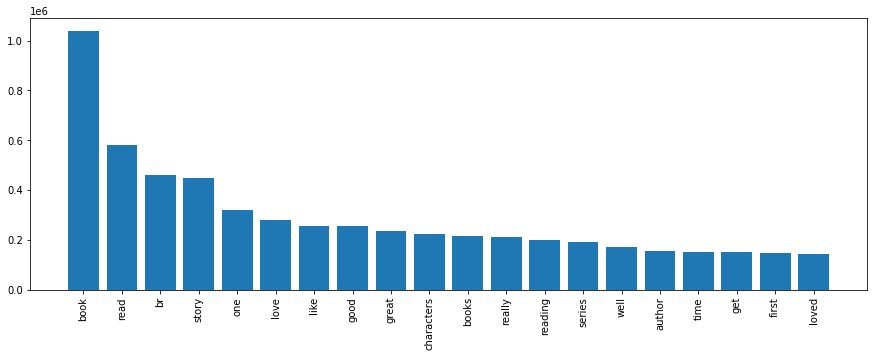

In [ ]:
plot_word_count(tokenized_clean, "clean_tokens")

In [ ]:
# tokenized_clean.count()

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from pyspark.sql.types import ArrayType,StringType

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
def get_wordnet_pos(treebank_tag):
  """
  return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
      """
  if treebank_tag.startswith('J'):
          return 'a'
  elif treebank_tag.startswith('V'):
          return 'v'
  elif treebank_tag.startswith('N'):
          return 'n'
  elif treebank_tag.startswith('R'):
          return 'r'
  else:
  # As default pos in lemmatization is Noun
      return 'n'
  
def lemmer(postags):
  lemmatizer = WordNetLemmatizer()
  x = [lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) for [word,pos_tag] in nltk.pos_tag(postags)]
  return x

In [ ]:
sparkLemmer = f.udf(lambda z: lemmer(z), ArrayType(StringType()))
tokenized_clean = tokenized_clean.select('product_id','tokens','clean_tokens',sparkLemmer('clean_tokens').alias('lems'))

In [ ]:
n=2
ngram = NGram(n=n)
ngram.setInputCol("lems").setOutputCol("nGrams")
tokenized_clean=ngram.transform(tokenized_clean)

# Groups reviews by producs

In [ ]:
tokens_by_prod = tokenized_clean.groupBy("product_id").agg(f.flatten(f.collect_list("nGrams")).alias("clean_tokens"))

In [ ]:
# tokens_by_prod.show(5, False)

# Representation

In [ ]:
# TF
countVec=CountVectorizer(inputCol='clean_tokens', outputCol='features')
countVec =countVec.fit(tokens_by_prod)
cv_df=countVec.transform(tokens_by_prod)
# cv_df.select(['product_id','features']).show(4,80)
# cv_df.show()

In [ ]:
# Hashing TF-IDF
numFeatures=2**10
hashingTF = HashingTF(inputCol="clean_tokens", outputCol="rawFeatures", numFeatures=numFeatures)
featurizedData = hashingTF.transform(tokens_by_prod)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
idf_features = idfModel.transform(featurizedData)
# idf_features.select("product_id", "features").show(10, 80)

In [ ]:
# featurizedData.show()

In [ ]:
# Word2Vec
word2Vec = Word2Vec(vectorSize=numFeatures, minCount=10, inputCol="clean_tokens", outputCol="features")
print(word2Vec.explainParams())
word2vec_model = word2Vec.fit(tokens_by_prod)
word2vec_features = word2vec_model.transform(tokens_by_prod)
# word2vec_features.select("product_id", "features").show(10, 80)

In [ ]:
# word2vec_features.count()

In [ ]:
model_word2v_path =  "/model_word2v"
word2vec_model.write().overwrite().save(model_word2v_path)

# Similitud

In [ ]:
bucket_length = 10 # Original 10
num_hash_tables = 30 # Original 20

In [ ]:
schema = StructType([ 
    StructField("review_body",StringType(),True), 
])
queries_list = [
 (["the greatest book of romance"],),
 (["the greatest book of love"],),
 (["action interesting book"],),
 (["gammer book"],),
 (["horror book"],),
 (["very terrifying book about vampires"],),
 (["a to learn about space"],),
 (["a book about soccer"],),
]
queries = spark.createDataFrame(queries_list, schema=schema)

In [ ]:
# swremover = StopWordsRemover(inputCol='tokens',outputCol='clean_tokens')
queries_clean = queries.withColumn('review_body', (f.lower(f.regexp_replace('review_body', "[^a-zA-Z\\s]", ""))))
tokenized_queries_clean=tokenizationML.transform(queries_clean).select(["tokens"])
tokenized_queries_clean = swremover.transform(tokenized_queries_clean)
tokenized_queries_clean = tokenized_queries_clean.select(sparkLemmer('clean_tokens').alias('lems'))
tokenized_queries_clean=ngram.transform(tokenized_queries_clean).select('nGrams').withColumnRenamed('nGrams','clean_tokens')
# tokenized_queries_clean.show(5)

In [ ]:
#hashingTF -> idfModel
#word2vec_model
queries_idf = idfModel.transform(hashingTF.transform(tokenized_queries_clean))
queries_w2v = word2vec_model.transform(tokenized_queries_clean)
# queries_w2v.show()

In [ ]:
# queries_idf.select("features").collect()[0]['features']

In [ ]:
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes", bucketLength=bucket_length, numHashTables=num_hash_tables)
model_lsh = brp.fit(queries_idf)
model_lsh2 = brp.fit(queries_w2v)

In [ ]:
neighborsidf=[]
neighborsw2v=[]
solucionidf=[]
solucionw2v=[]

for i in range(len(queries_list)):
  key = queries_idf.select("features").collect()[i]['features']
  neighborsidf.append(model_lsh.approxNearestNeighbors(idf_features, key=Vectors.dense(key), numNearestNeighbors=5).cache())
  key2 = queries_w2v.select("features").collect()[i]['features']
  neighborsw2v.append(model_lsh2.approxNearestNeighbors(word2vec_features, key=Vectors.dense(key2), numNearestNeighbors=5).cache())
  # neighborsw2v_df=neighborsw2v[i].withColumn('query',f.lit(queries_list[i]*5))
  solucionidf.append([queries_list[i],neighborsidf[i].select('product_id','clean_tokens').cache()])
  solucionw2v.append([queries_list[i],neighborsw2v[i].select('product_id','clean_tokens').cache()])

In [ ]:
for i in range(len(solucionidf)):
  print(solucionidf[i][0],solucionidf[i][1].show(5,False))

In [ ]:
for i in range(len(solucionw2v)):
  print(solucionw2v[i][0],solucionw2v[i][1].show(5,False))

In [ ]:
df.filter(df.product_id=='B00D64QVZ0').show(1,False)


In [ ]:
df.filter(df.product_id=='B008KFXQY4').show(1,False)

In [ ]:
key = queries_idf.select("features").collect()[2]['features']
neighbors = model_lsh.approxNearestNeighbors(idf_features, key=Vectors.dense(key), numNearestNeighbors=5).cache()
# neighbors.show(5, False)

In [ ]:
model_lsh_path =  "/model_lsh"
model_lsh.write().overwrite().save(model_lsh_path)

In [ ]:
key2 = queries_w2v.select("features").collect()[2]['features']
neighbors = model_lsh2.approxNearestNeighbors(word2vec_features, key=Vectors.dense(key2), numNearestNeighbors=5).cache()
# neighbors.show(5, False)

In [ ]:
model_lsh_path =  "/model_lsh2"
model_lsh2.write().overwrite().save(model_lsh_path)